** Notes **
* Be very careful when constructing the resolution matrix. If missed by a transpose, the result will be wrong!!

In [1]:
# %cd ~/dev/graphite-DOS/irradiated-notebooks/

In [1]:
from __future__ import (absolute_import, division, print_function)

import os, sys
import numpy as np
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
import warnings
from numpy import linalg as LA

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
sys.path.insert(0, '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/')
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [4]:
# sys.path.insert(0, '/home/lj7/dv/srins/srins/')
#sys.path.insert(0, '/SNS/users/lj7/dv/srins/srins/')

In [5]:
import srins

In [6]:
import srins.powder.linearizedBregman as splb; reload(splb)
import srins.powder.conv_deconv as spcd
import srins.powder.Lucy_Richardson as LR; reload(LR)
import srins.powder.bregmanSplit as spbs; reload(spbs)

<module 'srins.powder.bregmanSplit' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc'>

In [7]:
from srins.powder.conv_deconv import convolve_NS as F

In [8]:
Eaxis = np.arange(-50, 240, 0.1)

# Try deconvolving gaussian

In [9]:
def gauss(x, center, ht, sigma):
    return ht * np.exp(-(x-center)**2/2/sigma**2)

## Create resolution matrix

In [10]:
N = Eaxis.size

In [11]:
res_mat = np.zeros((N, N))

In [12]:
for i in range(N):
    tmp = gauss(Eaxis, Eaxis[i], 1., 3)
    tmp/=tmp.sum()
    res_mat[i] = tmp

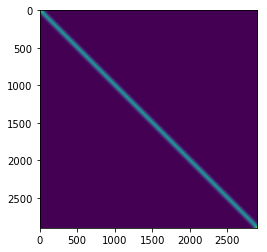

In [13]:
plt.figure()
plt.imshow(res_mat)

## Create delta function

In [14]:
print(np.where(np.isclose(Eaxis, 50.)))
print(np.where(np.isclose(Eaxis, 90.)))

(array([1000]),)
(array([1400]),)


In [15]:
y_delta = np.zeros(N)
y_delta[1000] = y_delta[1400] = 1.

## delta function convolved with resolution function

In [16]:
y_orig = y_delta

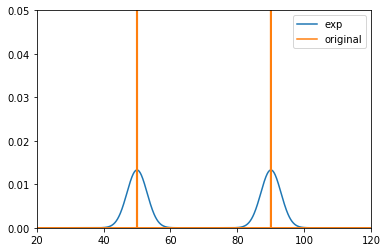

In [17]:
plt.figure()
y_exp = np.dot(y_orig, res_mat)
plt.plot(Eaxis, y_exp, label='exp')
plt.plot(Eaxis, y_orig, label='original')
plt.xlim(20, 120)
plt.ylim(0, 0.05)
plt.legend()

## Try simple inverse of matrix

In [18]:
res_mat_inv = np.linalg.inv(res_mat)

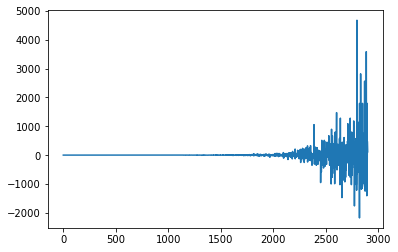

In [19]:
plt.figure()
plt.plot(np.dot(y_exp, res_mat_inv))

apparantly does not work!!!

## Linearized Bregman

In [20]:
RF_T = np.transpose(res_mat)
m = F(RF_T, res_mat)
max_delta = 2. / LA.norm(m, ord=1)
print (max_delta)

1.86494485797


In [21]:
import srins.powder.linearizedBregman as splb; reload(splb)

<module 'srins.powder.linearizedBregman' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc'>

In [22]:
ini_uZ = np.zeros(Eaxis.shape[0])
ini_vZ = np.zeros(Eaxis.shape[0])

In [23]:
delta = max_delta*.8

$\mu$

In [24]:
mu = np.linalg.norm(y_exp, 2)**2 / 2/delta/np.linalg.norm(y_exp,1)
print(mu)

0.00315128611096


In [25]:
RV, RU, error, it, errorBL = splb.bregman_NS(
    y_exp, res_mat, ini_vZ, ini_uZ, mu, delta, 'error', 0.0000001, maxIter=100)

number of iteration: 100


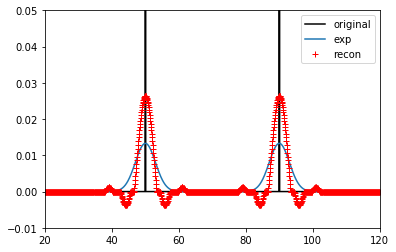

In [26]:
plt.figure()
plt.plot(Eaxis, y_orig, 'k', label='original')
plt.plot(Eaxis, y_exp, label='exp')
plt.plot(Eaxis, RU/RU.sum()*y_exp.sum(), 'r+', label='recon')
plt.xlim(20, 120)
plt.ylim(-0.01, 0.05)
plt.legend()

Cannot get delta function back

## Original peaks have widths

In [27]:
y_orig = gauss(Eaxis, 50, 1., 1) + gauss(Eaxis, 90, 1., 3)
y_exp = np.dot(y_orig, res_mat)

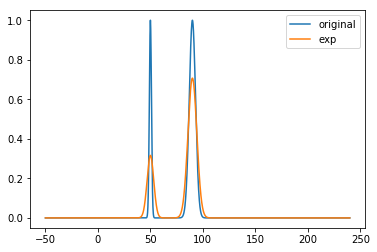

In [28]:
plt.figure()
plt.plot(Eaxis, y_orig, label='original')
plt.plot(Eaxis, y_exp, label='exp')
plt.legend()

$\mu$

In [29]:
mu = np.linalg.norm(y_exp, 2)**2 / 2/delta/np.linalg.norm(y_exp,1)
print(mu)

0.144408324459


In [30]:
RV, RU, error, it, errorBL = splb.bregman_NS(
    y_exp, res_mat, ini_vZ, ini_uZ, mu, delta, 'error', 1e-5, maxIter=100)

number of iteration: 29


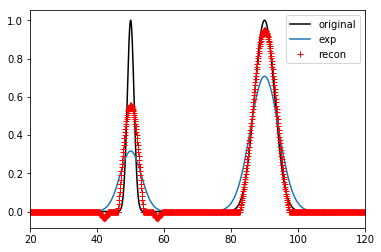

In [31]:
plt.figure()
plt.plot(Eaxis, y_orig, 'k', label='original')
plt.plot(Eaxis, y_exp, label='exp')
plt.plot(Eaxis, RU/RU.sum()*y_exp.sum(), 'r+', label='recon')
plt.xlim(20, 120)
plt.legend()

In [32]:
left = RV[Eaxis<70]
Eaxis_left = Eaxis[Eaxis<70]
Mag = np.max(left)
upper = Eaxis_left[left>Mag/2]
print((upper[-1]-upper[0])/2.355)

2.46284501062


# Try deconvoling triangle resolution

In [33]:
def tri(x, center, ht, sigma):
    y = x*0
    y[x>center] = ht - (x[x>center]-center)/sigma*ht
    y[y<0] = 0
    return y

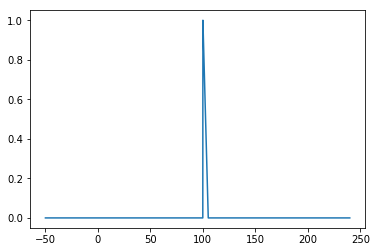

In [34]:
plt.figure()
plt.plot(Eaxis, tri(Eaxis, 100., 1., 5))

## Create resolution matrix

In [35]:
N = Eaxis.size

In [36]:
res_mat = np.zeros((N, N))

In [37]:
for i in range(N):
    tmp = tri(Eaxis, Eaxis[i], 1., 6)
    if tmp.sum()>0:
        tmp/=tmp.sum()
    res_mat[i] = tmp

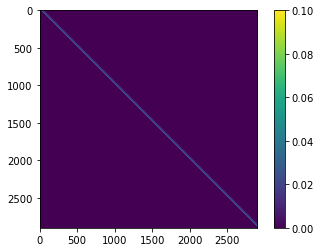

In [38]:
plt.figure()
plt.imshow(res_mat)
plt.clim(0, 0.1)
plt.colorbar()

## delta function convolved with resolution function

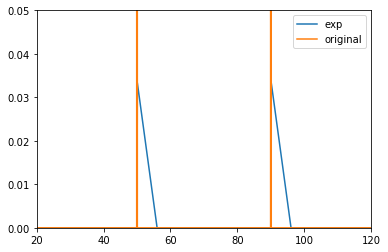

In [39]:
plt.figure()
y_exp = np.dot(y_delta, res_mat)
plt.plot(Eaxis, y_exp, label='exp')
plt.plot(Eaxis, y_delta, label='original')
plt.xlim(20, 120)
plt.ylim(0, 0.05)
plt.legend()

## Linearized Bregman

In [40]:
RF_T = np.transpose(res_mat)
m = F(RF_T, res_mat)
max_delta = 2. / LA.norm(m, ord=1)
print (max_delta)

0.497605052307


$\delta$

In [41]:
delta = max_delta*.8

$\mu$

In [42]:
mu = np.linalg.norm(y_exp, 2)**2 / 2/delta/np.linalg.norm(y_exp,1)
print(mu)

0.0281480086912


In [43]:
mu = 0.005

In [44]:
ini_uZ = np.zeros(Eaxis.shape[0])
ini_vZ = np.zeros(Eaxis.shape[0])

In [45]:
RV, RU, error, it, errorBL = splb.bregman_NS(
    y_exp, res_mat, ini_vZ, ini_uZ, mu, delta, 'error', 1e-7, maxIter=100)

number of iteration: 100


In [46]:
y_orig = y_delta

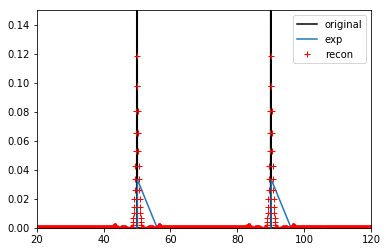

In [47]:
plt.figure()
plt.plot(Eaxis, y_orig, 'k', label='original')
plt.plot(Eaxis, y_exp, label='exp')
plt.plot(Eaxis, RU/RU.sum()*y_exp.sum(), 'r+', label='recon')
plt.xlim(20, 120)
plt.ylim(0, 0.15)
plt.legend()